# Check correlation between features selected for the model

## Plain English summary

We have made our model more simple by selecting the 10 features that give the best model performance, when chosen sequentially. 

We found that a model with eight features is able to provide 99% of the accuracy obtained when all 84 features are used, however we extended our feature inclusion to the top 10 features based on observing that clinicians, when they were discussing whether a particular patient was suitable to recieve thrombolysis, they would often discuss the patients age. Patient age was the 10th feature to be selected by this process. We decided to extend the feature selected list to include the 9th and 10th selected features: onset during sleep and patient age. This model provided >99% of the accuracy obtained when all 84 features are used. 

We are using Shapley values to help to explain how the model has arrived at each prediction. Shapley values require the features to be independent of each other. Any dependencies makes it extremely tricky, and messy, to unpick the allocation to each feature. Here we test the independencies by calculating the correlation between the 9 selected features (after removing stroke team). 

These ten features are largely independent of each other. There are only very weak correlations between the selected features with no feature explaining more than 15% of the variability of another feature, and all but two feature pairings (*age* with *prior disability*, and *onset during sleep* with *precise onset time*) explaining less than 5% of the variablility of another feature. 

## Data and analysis

Using the full dataset, calculate the correlation between each of these 7 features (the 7 top features sequentially chosen as having the single best improvement in the XGBoost model performance, using the ROC AUC, after removing stroke).

* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke severity: Stroke severity (NIHSS) on arrival
* Age: Age (as middle of 5 year age bands)
* Year: Year of stroke onset
* NIHSS arrival loc: Component of the NIHSS, level of consciousness on arrival
* Scan to thrombolysis time: Time from scan to receiving thrombolysis (minutes)
* Thrombolysis no but improving: Reason given for not receving thrombolysis is the patient is improving

Repeat the correlation analysis for these 7 features (the features have been chosen to be used to train the predictive model):

* Prior disability level: Disability level (modified Rankin Scale) before stroke
* Stroke severity: Stroke severity (NIHSS) on arrival
* Stroke team: Stroke team that the patient attended
* Age: Age (as middle of 5 year age bands)
* Onset to thrombolysis time: Time from onset to receiving thrombolysis (minutes). Set to -100 if did not recieve thrombolysis.
* Any afib diagnosis: Patient has a diagnosis of atrial fibrillation (either on arrival or new)
* Precise onset known: Onset time recorded is  precise time (not a best estimate)

## Aim

* Check correlation (by calculating the correlation) between the 7 top features as selected by sequential feature selection (after removing stroke team), and the 6 features chosen to train the predictive model (after removing stroke team)

## Observations
There are only very weak correlations between the selected features with no R-squared being greater than 0.45, and all but two being lower than 0.05.

Useful text for later?
* Stroke team: Stroke team that the patient attended
* NIHSS arrival best language: Component of the NIHSS, level of comprehension on arrival
* New afib diagnosis: Patient has a new diagnosis of atrial fibrillation on arrival
* NIHSS arrival sensory: Level of touch sensory
* Atrial fibrillation: Patient arrives with an existing atrial fibrillation diagnosis
* NIHSS arrival facial palsy: Component of the NIHSS, level of facial paralysis on arrival
* Thrombolysis no but other medical: Reason given for not receving thrombolysis is the patient is other medical

## Import libraries

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
import json
from dataclasses import dataclass
import time
import os
import seaborn as sns


Report the time duration to run notebook

In [43]:
start_time = time.time()

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [44]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output'
    notebook: str = '030_'

paths = Paths()

## Read in JSON file

Contains a dictionary for plain English feature names for the 10 features selected in the model. Use these as the column titles in the DataFrame.

In [45]:
filename = os.path.join(paths.data_save_path, 
                       ('020_feature_name_dict.json'))
with open(filename) as json_file:
    feature_name_dict = json.load(json_file)

## Load data

Combine all of the data (create a dataframe that includes every instance)

In [46]:
filename = os.path.join(paths.data_read_path, '02_reformatted_data_ml.csv')
data = pd.read_csv(filename)
# remove column
if 'id' in data.columns: data.drop(['id'],axis=1,inplace=True)

## Load features to use (drop stroke team if present)

Look at the correlation for two different sets of features:
1. the set from choosing sequentially

In [47]:
# Read in the names of the selected features for the model
filename = os.path.join(paths.data_save_path, 
                       ('020_feature_selection.csv'))
key_features = pd.read_csv(filename)

number_of_features_to_use = 7
key_features = list(key_features['feature'])[:number_of_features_to_use]

# Drop stroke team if present
if 'stroke_team' in key_features:
    key_features.remove('stroke_team')

2. the set from an informed choice from the sequential order

In [48]:
chosen_features = ['prior_disability','stroke_severity','age',
                     'onset_to_thrombolysis_time','any_afib_diagnosis',
                     'precise_onset_known']

Put information in lists (the list of features, and the title to accomapny these feature choices)

In [49]:
subset_features = [key_features, chosen_features]
subset_titles = ["Sequentially selecting features", "Features in the predictive model"]

### Define functions for the notebook

#### Function to standardise the feature data

In [50]:
def standardise_data(data):
    sc = StandardScaler() 
    sc.fit(data)
    data_std = sc.transform(data)
    data_std = pd.DataFrame(data_std, columns=list(data))
    return(data_std)

#### Function to calculate correlation between features

In [51]:
def calc_correlation(data_std):
    # Get covariance
    cov = data_std.cov()

    # Convert from wide to tall
    cov = cov.melt(ignore_index=False)

    # Remove self-correlation
    mask = cov.index != cov['variable']
    cov = cov[mask]

    # Add absolute value
    cov['abs_value'] = np.abs(cov['value'])

    # Add R-squared
    cov['r-squared'] = cov['value'] ** 2

    # Sort by absolute covariance
    cov.sort_values('abs_value', inplace=True, ascending=False)

    # Round to four decimal places
    cov = cov.round(4)

    # Remove duplicate pairs of features
    result = []
    for index, values in cov.iterrows():
        combination = [index, values['variable']]
        combination.sort()
        string = combination[0] + "-" + combination[1]
        result.append(string)
    cov['pair'] = result
    cov.sort_values('pair', inplace=True)
    cov.drop_duplicates(subset=['pair'], inplace=True)
    cov.drop('pair', axis=1, inplace=True)

    # Sort by r-squared
    cov.sort_values('r-squared', ascending=False, inplace=True)

    return(cov)

In [52]:
# Restrict data to chosen features
for features, title in zip(subset_features, subset_titles):

    # Use just the features in the subset
    data_subset = data[features]

    # Standardise data. After scaling data, the reported covariance will be the
    # correlation between data features.
    data_std = standardise_data(data_subset)

    # Rename columns to plain English
    data_std.rename(columns=feature_name_dict, inplace=True)

    # Calculate covariance
    cov = calc_correlation(data_std)

    # Display R-squared (sorted by R-squared)
    print(f'Results for {title} (showing most correlated feature pairs)')
    print()
    print(cov[['variable', 'r-squared']][:10])
    print()


Results for Sequentially selecting features (showing most correlated feature pairs)

                                            variable  r-squared
Stroke severity                    NIHSS arrival loc     0.3233
Age                           Prior disability level     0.1411
Prior disability level               Stroke severity     0.0707
Scan-to-thrombolysis time            Stroke severity     0.0589
Age                                  Stroke severity     0.0356
NIHSS arrival loc             Prior disability level     0.0322
Age                                NIHSS arrival loc     0.0151
Scan-to-thrombolysis time     Prior disability level     0.0142
Age                        Scan-to-thrombolysis time     0.0061
NIHSS arrival loc                               Year     0.0009

Results for Features in the predictive model (showing most correlated feature pairs)

                                              variable  r-squared
Prior disability level                             Age    

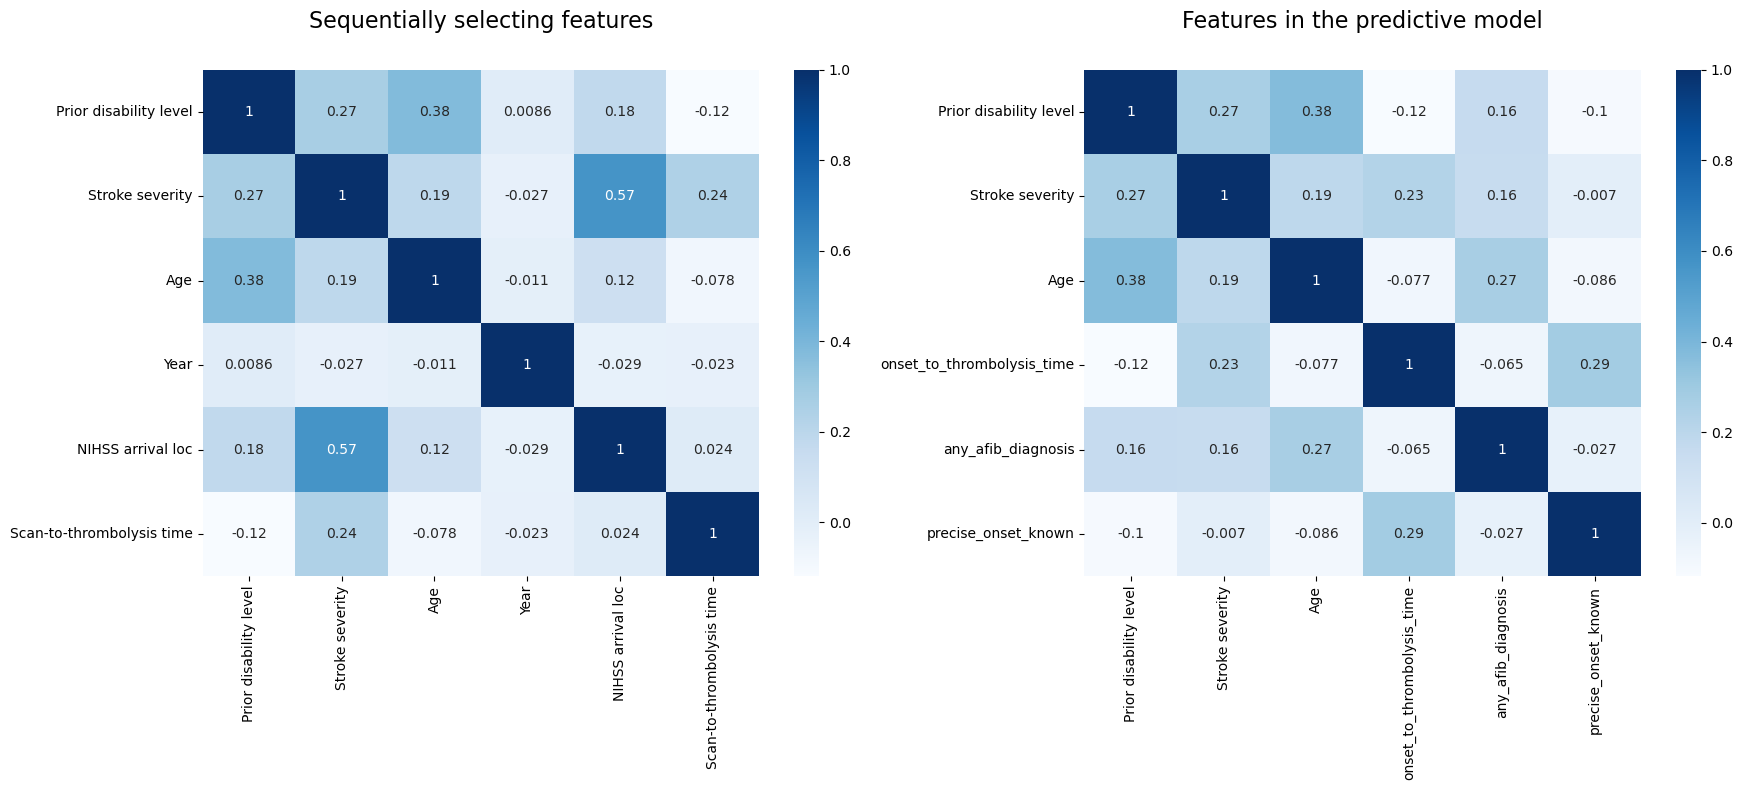

In [53]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,8))

# Legend height
shrink = 0.5

# Restrict data to chosen features
for features, title, ax in zip(subset_features, subset_titles, axs):

    # Use just the features in the subset
    data_subset = data[features]

    # Standardise data. After scaling data, the reported covariance will be the
    # correlation between data features.
    data_std = standardise_data(data_subset)

    # Rename columns to plain English
    data_std.rename(columns=feature_name_dict, inplace=True)

    data_corr = data_std.corr()
    sns.heatmap(data_corr, xticklabels=data_corr.columns, 
                yticklabels=data_corr.columns, cmap="Blues", annot=True, ax=ax)
    ax.set_title(title, pad=30, fontsize=16)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + '_correlation_heatmaps.jpg'))

plt.savefig(filename, dpi=300)

plt.tight_layout()

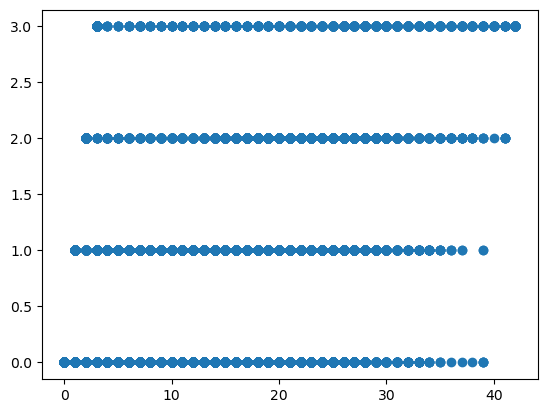

In [58]:
#features = ["stroke_severity","NIHSS_arrival_loc"]
#data_subset = data[features]
plt.scatter(data["stroke_severity"], data["nihss_arrival_loc"])

In [60]:
data["stroke_severity","nihss_arrival_loc"]

['stroke_severity', 'nihss_arrival_loc']

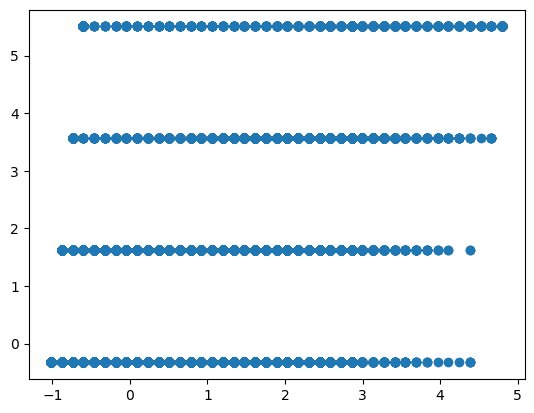

In [61]:
data_std = standardise_data(data[["stroke_severity","nihss_arrival_loc"]])
plt.scatter(data_std["stroke_severity"], data_std["nihss_arrival_loc"])


In [73]:
def assignIDs(list):
    '''Take a list of strings, and for each unique value assign a number.
    Returns a map for "unique-val"->id.
    '''
    sortedList = sorted(list)

    #taken from
    #http://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-in-python-whilst-preserving-order/480227#480227
    seen = set()
    seen_add = seen.add
    uniqueList =  [ x for x in sortedList if x not in seen and not seen_add(x)]

    return  dict(zip(uniqueList,range(len(uniqueList))))

In [78]:
def plotData(data,color):
    x = data.iloc[:, 0]
    y = data.iloc[:,1]

    xMap = assignIDs(x)
    xAsInts = np.array([xMap[i] for i in x])

    pearR = np.corrcoef(xAsInts,y)[1,0]
    # least squares from:
    # http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html
    A = np.vstack([xAsInts,np.ones(len(xAsInts))]).T
    m,c = np.linalg.lstsq(A,np.array(y))[0]

    plt.scatter(xAsInts,y,label='Data '+color,color=color)
    plt.plot(xAsInts,xAsInts*m+c,color=color,
             label="Fit %6s, r = %6.2e"%(color,pearR))
    plt.xticks(xMap.values(),xMap.keys())
    plt.legend(loc=3)

In [89]:
x = data["stroke_severity"]
x = data["nihss_loc"]
xAsInts = np.array([xMap[i] for i in x])
np.corrcoef(xAsInts,y)[1,0]

168347

/tmp/ipykernel_161038/1539484287.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m,c = np.linalg.lstsq(A,np.array(y))[0]


ValueError: 'locs' must be 1D with shape (M,). Your input has shape ().

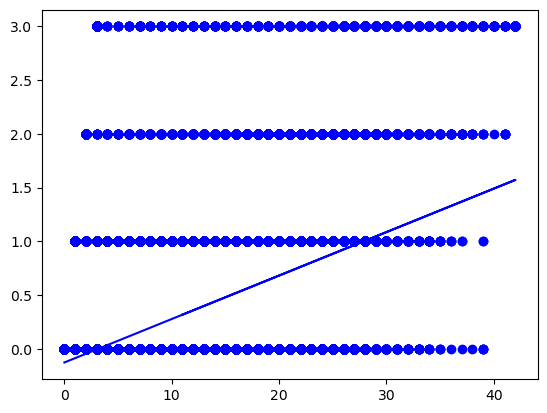

In [79]:
plotData(data[["stroke_severity", "nihss_arrival_loc"]],'blue')
plotData(data_std[["stroke_severity", "nihss_arrival_loc"]],'red')
#plt.gcf().savefig("correlation.png")

In [65]:
DATA = [
    ('a', 4),
    ('b', 5),
    ('c', 5),
    ('d', 4),
    ('e', 2),
    ('f', 5),
]
DATA

[('a', 4), ('b', 5), ('c', 5), ('d', 4), ('e', 2), ('f', 5)]

In [70]:
d=data[["stroke_severity", "nihss_arrival_loc"]]

In [72]:
d.iloc[:,0]
#    y = data.loc[1]


0          0
1         12
2         10
3         12
4          2
          ..
168342    27
168343     7
168344     0
168345     2
168346    11
Name: stroke_severity, Length: 168347, dtype: int64

## Observations

There are only very weak correlations between the selected features with no R-squared being greater than 0.15, and all but two being lower than 0.05.